In [65]:
from itertools import product

import graspologic as gp
import matplotlib.pyplot as plt
import numpy as np
from graspologic.embed import AdjacencySpectralEmbed, OmnibusEmbed
from graspologic.plot import heatmap
from graspologic.simulations import p_from_latent, sample_edges
from joblib import Parallel, delayed

from pkg.inference.vertex_position_test import *
from pkg.inference.vertex_position_test import _bootstrap, _difference_norm, _embed

In [3]:
def compute_delta(p, eps):
    delta = ((p + eps) ** 2 - p**2) / p

    return delta


def sample_latent(n, p, eps, seed=None):
    ps = np.repeat(p, n).reshape(-1, 1)
    X = np.sqrt(ps)

    delta = compute_delta(p, eps)
    delta_vec = np.zeros((n, 1))
    delta_vec[0, 0] += delta

    Y = np.sqrt(ps + delta_vec)

    return X, Y


def sample_graphs(n, p, eps, seed=None):
    X, Y = sample_latent(n=n, p=p, eps=eps, seed=seed)

    P_X = gp.simulations.p_from_latent(X)
    P_Y = gp.simulations.p_from_latent(Y)

    np.random.seed(seed)
    A = gp.simulations.sample_edges(P_X)
    B = gp.simulations.sample_edges(P_Y)

    return A, B

In [74]:
def experiment(n, p, eps, test_case='rotation', alpha=0.05, n_reps=500, n_jobs=-1):
    def worker(seed):
        A, B = sample_graphs(n, p, eps, seed)
        _, pval, _, _ = vertex_position_test(A, B, n_components=2,test_case=test_case, n_bootstraps=500)  # rank 2 p matrix

        return pval.reshape(-1, 1)

    res = Parallel(n_jobs=n_jobs)(delayed(worker)(seed) for seed in range(n_reps))
    pvals = np.hstack(res)

    return pvals

In [75]:
n = 100
p = 0.25
eps = np.linspace(0, 0.75, 16)
test_cases = ["rotation", "scalar-rotation", "diagonal-rotation"]
n_reps = 500

args = [dict(n=n, p=p, test_case=t, eps=e) for t, e in product(test_cases, eps)]

In [76]:
res = []

for arg in args:
    # print(f"Running args: {arg}")
    res.append(experiment(**arg))

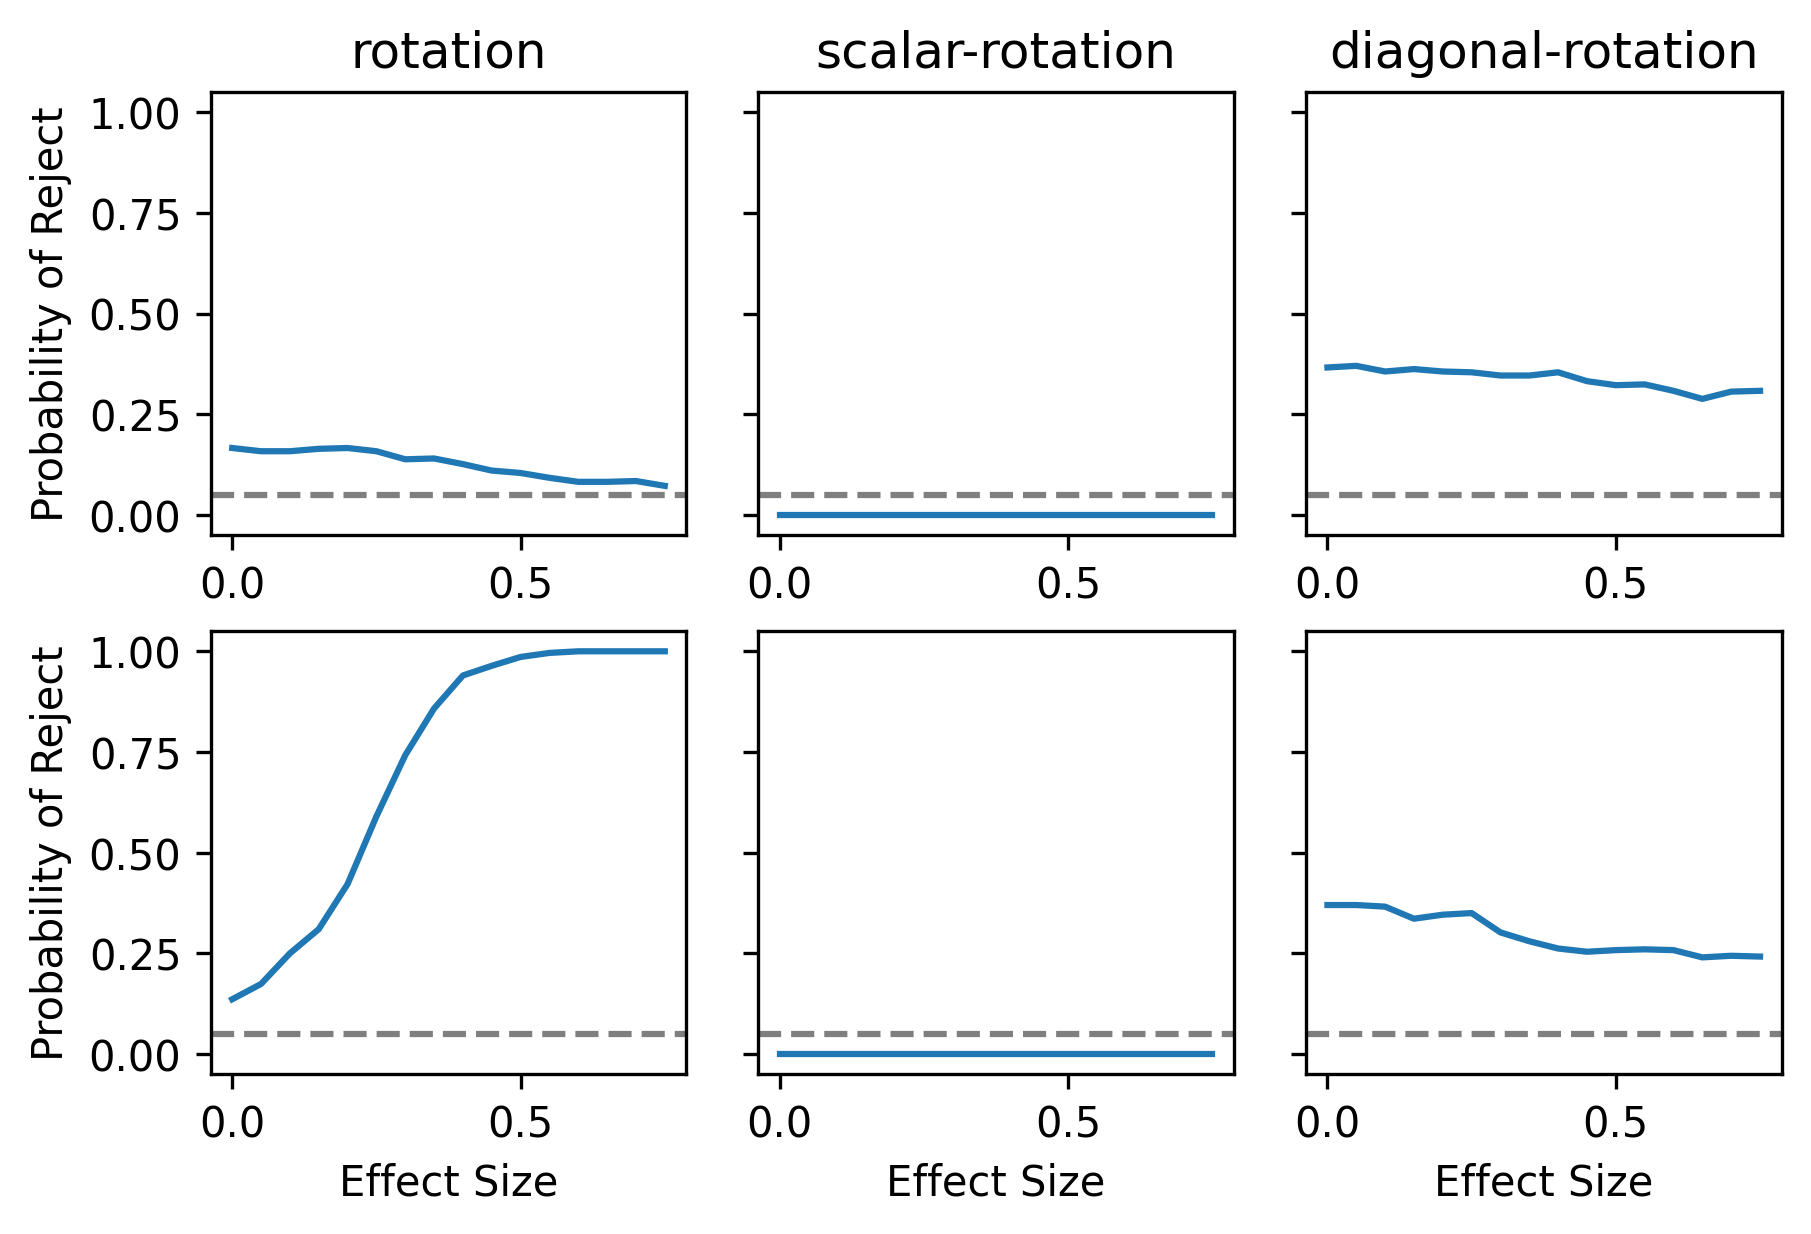

In [112]:
res_dict = {}

for i in range(len(res)):
    arg = args[i]
    r = res[i]
    
    key = arg['test_case'] +"_" + str(arg['eps'])
    
    res_dict[key] = (r <= 0.05).mean(axis=1)

fig, ax = plt.subplots(figsize=(6, 4), dpi=300, ncols = 3, nrows=2, sharey=True, constrained_layout=True)

for idx, test_case in enumerate(test_cases):
    power = []
    effect_size= []
    
    for key in res_dict.keys():
        if test_case == key.split("_")[0]:
            power.append(res_dict[key])
            effect_size.append(key.split("_")[1])
    
    vertex_changed = [p[0] for p in power]
    vertex_control = [p[1] for p in power]
    
    ax[0, idx].plot(eps, vertex_control)
    ax[1, idx].plot(eps, vertex_changed)
    
    ax[0, idx].axhline(0.05, ls='--', alpha=0.5, c='k')
    ax[1, idx].axhline(0.05, ls='--', alpha=0.5, c='k')
    ax[0, idx].set(title=test_case)
    
ax[0, 0].set(ylabel="Probability of Reject")
ax[1, 0].set(ylabel="Probability of Reject")

for i in range(3):
    ax[1, i].set(xlabel='Effect Size')
# ax[0, 0].yaxis.tick_right()

# ax.yaxis.set_label_position("right")

ax[0, -1].set(label="Unchanged Vertex")
ax[1, -1].set(label="Changed Vertex")
ax[0, -1].yaxis.set_label_position("right")


In [113]:
import pickle

In [116]:
with open("../results/outputs/2022-09-14-vertex-two-sample.pkl", 'wb') as f:
    pickle.dump(res_dict, f)

## Try different bootstraps

In [118]:
x = np.random.normal(size=(10, 2))

In [120]:
idx  = np.random.permutation(10)

In [121]:
x[idx]

array([[ 1.06262908,  0.6640431 ],
       [-0.22037341,  0.96321091],
       [-0.83853075, -1.61187109],
       [ 1.48144014, -0.47746846],
       [-0.38636561, -1.31219507],
       [ 0.45159684,  0.81404667],
       [-0.61306382,  0.18412894],
       [ 1.57017925, -1.4981266 ],
       [-2.1701255 ,  0.45554627],
       [-1.4089585 ,  0.95142513]])

In [122]:
x

array([[-2.1701255 ,  0.45554627],
       [ 1.48144014, -0.47746846],
       [ 0.45159684,  0.81404667],
       [-1.4089585 ,  0.95142513],
       [-0.38636561, -1.31219507],
       [ 1.57017925, -1.4981266 ],
       [-0.83853075, -1.61187109],
       [ 1.06262908,  0.6640431 ],
       [-0.61306382,  0.18412894],
       [-0.22037341,  0.96321091]])

In [123]:
idx

array([7, 9, 6, 1, 4, 2, 8, 5, 0, 3])

In [125]:
x[7]

array([1.06262908, 0.6640431 ])